In [146]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [147]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [148]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [149]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [150]:
# Import uuid library to generate unique image names
import uuid

In [151]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\131f986a-1d12-11ef-942f-ccc94933af89.jpg'

In [154]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

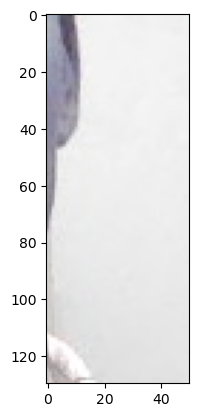

In [155]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [156]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [157]:
dir_test = anchor.as_numpy_iterator()

In [158]:
print(dir_test.next())

b'data\\anchor\\1d425a8e-1cf4-11ef-9608-ccc94933af89.jpg'


In [159]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [160]:
img = preprocess('data\\anchor\\17cd3e0e-1cf4-11ef-8dd6-ccc94933af89.jpg')

In [161]:
img.numpy().max() 

1.0

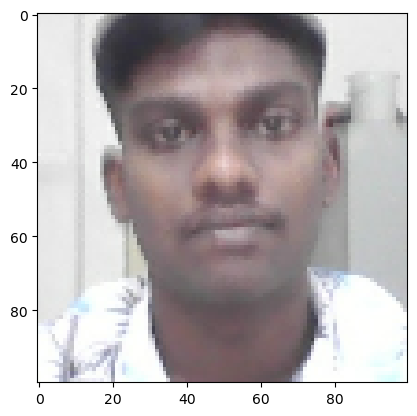

In [162]:
plt.imshow(img)

In [163]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [164]:
samples = data.as_numpy_iterator()

In [165]:
exampple = samples.next()

In [166]:
exampple

(b'data\\anchor\\16c35e72-1cf4-11ef-966b-ccc94933af89.jpg',
 b'data\\positive\\b25a68f7-1cf4-11ef-b11c-ccc94933af89.jpg',
 1.0)

In [167]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [168]:
res = preprocess_twin(*exampple)

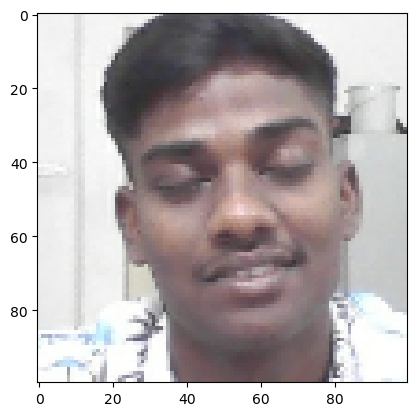

In [169]:
plt.imshow(res[1])

In [170]:
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9409314 , 0.9409314 , 0.9409314 ],
        [0.9482843 , 0.9482843 , 0.9482843 ],
        [0.9526961 , 0.9526961 , 0.9526961 ],
        ...,
        [0.94411767, 0.94411767, 0.94411767],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9411765 , 0.9411765 , 0.9411765 ]],

       [[0.94509804, 0.94509804, 0.94509804],
        [0.9497549 , 0.9497549 , 0.9497549 ],
        [0.9519608 , 0.9519608 , 0.9519608 ],
        ...,
        [0.9458333 , 0.9458333 , 0.9458333 ],
        [0.94142157, 0.94142157, 0.94142157],
        [0.9411765 , 0.9411765 , 0.9411765 ]],

       [[0.94803923, 0.94803923, 0.94803923],
        [0.9519608 , 0.9519608 , 0.9519608 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        ...,
        [0.9460784 , 0.9460784 , 0.9460784 ],
        [0.94215685, 0.94215685, 0.94215685],
        [0.9411765 , 0.9411765 , 0.9411765 ]],

       ...,

       [[0.99240196, 0.9992647 , 0.9943628 ],
        [0.99

In [171]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [172]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [173]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [174]:
inp = Input(shape=(100,100,3), name='input_image')

In [175]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [176]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [177]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [178]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [179]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [180]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [181]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [182]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [183]:
embedding = make_embedding()

In [184]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [185]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [186]:
l1 = L1Dist()

In [187]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [189]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [190]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [191]:
siamese_layer = L1Dist()

In [192]:
distances = siamese_layer(inp_embedding, val_embedding)

In [193]:
classifier = Dense(1, activation='sigmoid')(distances)

In [194]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [195]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [196]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [197]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [198]:
siamese_model = make_siamese_model()

In [199]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [200]:
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=True)

In [201]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [202]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [203]:
test_batch = train_data.as_numpy_iterator()

In [204]:
batch_1 = test_batch.next()

In [205]:
X = batch_1[:2]

In [206]:
y = batch_1[2]

In [207]:
y

array([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [208]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [209]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [210]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 78s 3s/step

 Epoch 2/50
27/27 [==============================] - 69s 3s/step

 Epoch 3/50
27/27 [==============================] - 69s 3s/step

 Epoch 4/50
27/27 [==============================] - 68s 3s/step

 Epoch 5/50
27/27 [==============================] - 69s 3s/step

 Epoch 6/50
27/27 [==============================] - 69s 3s/step

 Epoch 7/50
27/27 [==============================] - 69s 3s/step

 Epoch 8/50
27/27 [==============================] - 69s 3s/step

 Epoch 9/50
27/27 [==============================] - 69s 3s/step

 Epoch 10/50
27/27 [==============================] - 72s 3s/step

 Epoch 11/50
27/27 [==============================] - 69s 3s/step

 Epoch 12/50
27/27 [==============================] - 69s 3s/step

 Epoch 13/50
27/27 [==============================

In [96]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [97]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [98]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[5.77178900e-04],
       [9.99947250e-01],
       [5.63651140e-11],
       [9.96856928e-01],
       [5.31857056e-13],
       [7.51665950e-01],
       [3.52306877e-08],
       [8.28934729e-01],
       [5.84017695e-11],
       [9.99702811e-01],
       [9.60372388e-01],
       [1.91466107e-10],
       [8.89332056e-01],
       [1.11565196e-13],
       [1.53246287e-11],
       [7.60131598e-01]], dtype=float32)

In [99]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]

In [100]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [101]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [102]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

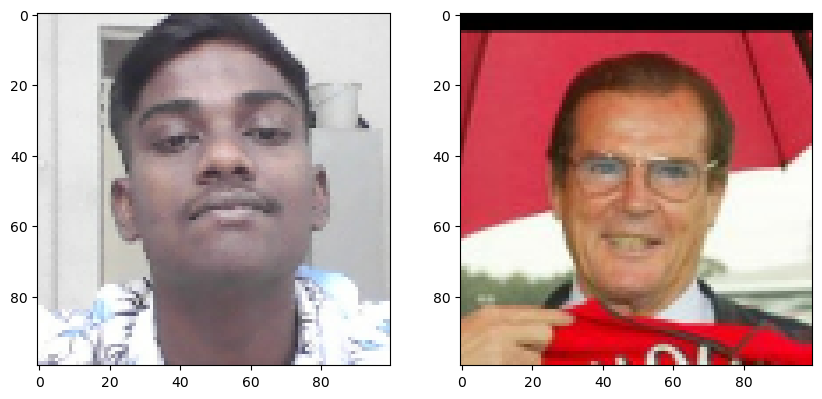

In [103]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [104]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [105]:
L1Dist

__main__.L1Dist

In [106]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [107]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 877ms/step


array([[5.7717890e-04],
       [9.9994791e-01],
       [5.6365114e-11],
       [9.9685693e-01],
       [1.7904196e-13],
       [8.3647591e-01],
       [3.9062328e-08],
       [9.1197079e-01],
       [5.8933400e-11],
       [9.9914277e-01],
       [9.6037239e-01],
       [3.8910294e-10],
       [8.8933206e-01],
       [4.4615885e-14],
       [1.6240740e-11],
       [7.6013160e-01]], dtype=float32)

In [108]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [109]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [110]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00a833aa-1cf3-11ef-ada3-ccc94933af89.jpg',
 '00b6a93a-1cf3-11ef-af52-ccc94933af89.jpg',
 '00c4e95d-1cf3-11ef-8133-ccc94933af89.jpg',
 '00d422f0-1cf3-11ef-840d-ccc94933af89.jpg',
 '00e12847-1cf3-11ef-bf93-ccc94933af89.jpg',
 '00e94860-1cf3-11ef-951d-ccc94933af89.jpg',
 '00ef9b92-1cf3-11ef-b51e-ccc94933af89.jpg',
 '015bf415-1cf3-11ef-ba41-ccc94933af89.jpg',
 '022ad5cb-1cf3-11ef-a7ae-ccc94933af89.jpg',
 '02a674eb-1cf3-11ef-919e-ccc94933af89.jpg',
 '04e61fee-1cf3-11ef-abe9-ccc94933af89.jpg',
 '05a55484-1cf3-11ef-bb89-ccc94933af89.jpg',
 '05e6286a-1cf3-11ef-8511-ccc94933af89.jpg',
 '06a9e674-1cf3-11ef-b683-ccc94933af89.jpg',
 '06bb5dc3-1cf3-11ef-aa77-ccc94933af89.jpg',
 '07ea156e-1cf3-11ef-beea-ccc94933af89.jpg',
 '08e0e1bd-1cf3-11ef-82bf-ccc94933af89.jpg',
 '08fd92bf-1cf3-11ef-b774-ccc94933af89.jpg',
 '0a26948a-1cf3-11ef-a9b7-ccc94933af89.jpg',
 '0a45c503-1cf3-11ef-81c9-ccc94933af89.jpg',
 '0a9831f6-1cf3-11ef-be66-ccc94933af89.jpg',
 '0ab195a4-1cf3-11ef-8e3e-ccc94933af89.jpg',
 '14f16275

In [112]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [113]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00a833aa-1cf3-11ef-ada3-ccc94933af89.jpg
application_data\verification_images\00b6a93a-1cf3-11ef-af52-ccc94933af89.jpg
application_data\verification_images\00c4e95d-1cf3-11ef-8133-ccc94933af89.jpg
application_data\verification_images\00d422f0-1cf3-11ef-840d-ccc94933af89.jpg
application_data\verification_images\00e12847-1cf3-11ef-bf93-ccc94933af89.jpg
application_data\verification_images\00e94860-1cf3-11ef-951d-ccc94933af89.jpg
application_data\verification_images\00ef9b92-1cf3-11ef-b51e-ccc94933af89.jpg
application_data\verification_images\015bf415-1cf3-11ef-ba41-ccc94933af89.jpg
application_data\verification_images\022ad5cb-1cf3-11ef-a7ae-ccc94933af89.jpg
application_data\verification_images\02a674eb-1cf3-11ef-919e-ccc94933af89.jpg
application_data\verification_images\04e61fee-1cf3-11ef-abe9-ccc94933af89.jpg
application_data\verification_images\05a55484-1cf3-11ef-bb89-ccc94933af89.jpg
application_data\verification_images\05e6286a-1cf3-11ef-8511-ccc

In [114]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [142]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 62ms/step
False
1/1 [==============================] - 0s 110ms/step
True
1/1 [==============================] - 0s 102ms/step
True
1/1 [==============================] - 0s 86ms/step
False
1/1 [==============================] - 0s 90ms/step
False
1/1 [==============================] - 0s 85ms/step
True


In [145]:
np.sum(np.squeeze(results) > 0.9)

13

In [131]:
33/50

0.66